# Document Similarity
### Using FastText Word Embedding
https://fasttext.cc/docs/en/aligned-vectors.html

In [1]:
import warnings
warnings.filterwarnings("ignore")
from gensim.models import KeyedVectors
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pickle
import operator

# import natural language toolkit
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation
from nltk.corpus   import stopwords
from nltk.tokenize import word_tokenize

import string

In [2]:
from modules.library.postgresql import PostgresQL
# # connect to the postgresql database
pg = PostgresQL() 
pg.connect(database="eurlex_environment_only", user="postgres", password="dbpass")

In [14]:
from modules.library.word_models import WordModels

In [15]:
from modules.library.document_similarity import DocumentSimilarity

In [16]:
from modules.library.document_models import DocumentModels

In [3]:
rand_seed = 4

In [4]:
with open('objs.pkl', "rb") as f:
    e = pickle.load(f)

In [5]:
wv_en_align = e[0]
documents = e[1]
documents_stripped = e[2]
we = e[3]
docembeddings_transformed = e[4]
XX = e[5]
all_descriptors = e[6]
descriptors_embedding = e[7] 
descriptors_embedding_transformed = e[8]
we_trained = e[9]
trained_docemb_transformed = e[10]
tr_desc_emb = e[11]
tr_desc_emb_transformed = e[12]'

Importing pre-trained FastText word embeddings of English words. We chose to use aligned word vectors, which will enable us to provide cross-lingual support.

In [17]:
# wiki_en_align = '../data/fasttext/wiki.en.align.vec'
# wiki_en_model = WordModels()
# wiki_en_model.load(wiki_en_align)
# print('english words {}'.format(len(list(wiki_en_model.embedding.vocab.keys()))))

english words 2519370


In [8]:
# with open("wwe.pkl", "wb") as f:
#     pickle.dump(wv_wiki_en, f, protocol=-1)

In [9]:
with open("wwe.pkl", "rb") as f:
    wv_wiki_en = pickle.load(f)

Importing documents from EUR-Lex database.

## Processing Data

Preparing list of stopwords (words that appear regularly in the vocabulary and are not so significant for a specific document).

In [10]:
# prepare stopword list
stop_words = stopwords.words('english') + list(string.punctuation)

Tokenize the text of the document - remove stopwords and punctuation and split it in words. We also count the occurance of words in the document and order them by number of occurances decreasingly.

In [11]:
# %load -s tokenize document_embeddings.py
def tokenize(text, stop_words):
    """Tokenizes and removes stopwords from the document"""

    def strip_comments(s):
        s = s.replace('"', '')
        s = s.replace("'", '')
        s = s.replace('“', '')
        s = s.replace('”', '')
        return s

    CUSTOM_FILTERS = [lambda x: x.lower(), strip_punctuation]

    stripped_text = strip_comments(text)
    tokens = preprocess_string(stripped_text, CUSTOM_FILTERS)
    filtered = [w for w in tokens if not w in stop_words]

    #return filtered
    # get the most frequent words in the document
    count = { }
    for word in filtered:
        if word not in count:
            count[word] = 0
        count[word] += 1

    word_sorted = sorted(count.items(), key=operator.itemgetter(1), reverse=True)
    return word_sorted


In [17]:
# %load -s euclid_similarity document_embeddings.py
def euclid_similarity(emb1, emb2):
    """Calculate the euclid similarity between two embeddings"""
    return np.linalg.norm(emb1 - emb2)


In [18]:
type(euclid_similarity(we[0], we[1]))

numpy.float32

## Document embeddings

In this section we write several document embeddings. They will be used later to find the optimal way to represent our data.

Save all documents of EUR-Lex database into a variable 'documents'.

In [19]:
# documents = pg.execute("""
#     SELECT * FROM documents;
# """)

In [18]:
N = len(documents)
print(N)

123157


In [21]:
# %load -s strip document_embeddings.py
def strip(s, stopwords):
    s = s.replace('"', '')
    s = s.replace("'", '')
    s = s.replace('“', '')
    s = s.replace('”', '')
    for w in stopwords:
        s = s.replace(w, '')
    return strip_punctuation(s)


In [22]:
# documents_stripped = [strip(d['document_text'], stop_words) for d in documents]

### Document embedding via word embeddings

We will first implement a simple version of document embedding that relies on the fact, that we already have a basis of word embeddings. Document embedding will be defined as an average of word embeddings of words that appear in 'document_text'.

In [23]:
# %load -s simple_docemb document_embeddings.py
def simple_docemb(text, stopwords, wv):
    """Creates a document embedding as the average of corresponding token embeddings"""
    embedding = np.zeros(wv.vector_size, dtype=np.float32)

    if text is None:
        return embedding

    word_sorted = tokenize(text, stopwords)
    norm = 0
    for token in word_sorted:
        # sum all tokens embeddings of the vector
        if token in wv.vocab.keys():
            embedding += wv[token]
            norm += 1
    # return the normalized embedding; if not zero
    return embedding if norm == 0 else embedding / norm


We embed documents in our database. As shown before the total number of documents in the database is more than 100.000, so we limit ourselves and embed only 15.000.

In [24]:
# %load -s dataset_embedding document_embeddings.py
def dataset_embedding(dataset, stopwords, wv, document_embedding):
    """Creates the dataset embeddings given a document_embedding function"""

    embeddings = np.zeros((len(dataset), wv.vector_size), dtype=np.float32)
    for id, document in enumerate(dataset):
        text = document['document_text']
        embeddings[id,:] = document_embedding(text, stopwords, wv)
        if id % 10000 == 0:
            print('Processed document number = {}'.format(id))
    return embeddings


In [28]:
# limit = 15000
# we = dataset_embedding(documents[:limit], stop_words, wv_wiki_en, simple_docemb)

We filter through them and pick only the ones with non-zero embeddings (the ones with 'document_text' differet then 'None').

In [29]:
non_null = [x for x in we if np.linalg.norm(x) != 0]
non_null_id = [i for i in range(len(we)) if np.linalg.norm(we[i]) != 0]
len(non_null)

15000

In order to plot the embeddings we need to reduce the dimension to 2 (or 3). We use the TSNE method and plot the embeddings.

In [30]:
# docembeddings_transformed = TSNE(n_components=2, random_state=rand_seed).fit_transform(non_null)

In [31]:
XX = docembeddings_transformed[:4000, :]
XX.shape

(4000, 2)

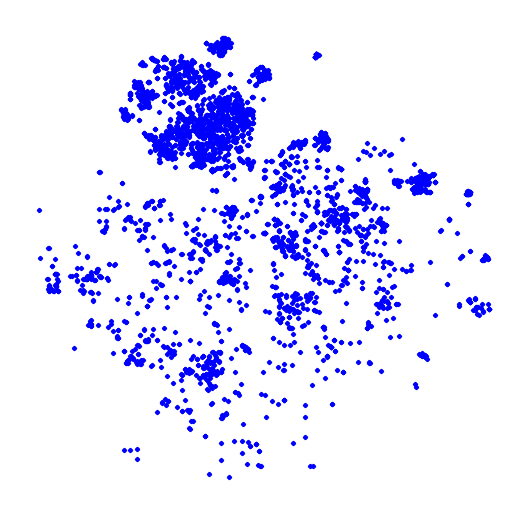

In [32]:
# get the (x, y) coordinates
x, y = XX.transpose()[0], XX.transpose()[1]
# draw the points into the landscape
fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')
ax.scatter(x,  y,  2, marker='x', c='b')
# show the image
plt.axis('off')
plt.show()

### Document embedding via document descriptors

We can consider document descriptors to be some kind of summary of the document. We will use them to define a document embedding as the average of word embeddings of words that appear in document descriptors.

Let's first see how to access descriptors of the document with CELEX number 22015P0513(01).

In [33]:
descriptors = pg.execute("""
    SELECT * FROM document_descriptors WHERE document_celex_num='22015P0513(01)';
""")

In [34]:
print(descriptors)
#print(descriptors[0]['descriptor_name'])

[{'document_celex_num': '22015P0513(01)', 'descriptor_name': 'Africa'}, {'document_celex_num': '22015P0513(01)', 'descriptor_name': 'deforestation'}, {'document_celex_num': '22015P0513(01)', 'descriptor_name': 'Democratic Republic of the Congo'}, {'document_celex_num': '22015P0513(01)', 'descriptor_name': 'disease prevention'}, {'document_celex_num': '22015P0513(01)', 'descriptor_name': 'economic cooperation'}, {'document_celex_num': '22015P0513(01)', 'descriptor_name': 'international cooperation'}, {'document_celex_num': '22015P0513(01)', 'descriptor_name': 'nature reserve'}]


We gather them in a dictionary 'all_descriptors', where keys are CELEX numbers of documents and values are lists of their descriptors.

In [35]:
# %load -s get_descriptors document_embeddings.py
def get_descriptors(indices, documents):
    """Returns a dictionary of descriptors for specified documents"""

    # The function returns dictionary 'descriptors' where keys are CELEX numbers of documents and values are descriptors
    # that correspond to appropriate document
    descriptors = {}

    for i in indices:
        celex = documents[i]['document_celex_num']
        doc_descriptors = pg.execute("""
            SELECT * FROM document_descriptors WHERE document_celex_num='{}';
            """.format(celex))
        for descriptor_instance in doc_descriptors:
            if celex not in descriptors:
                descriptors[celex] = [descriptor_instance['descriptor_name']]
            else:
                descriptors[celex].append(descriptor_instance['descriptor_name'])
    return descriptors


In [36]:
# all_descriptors = get_descriptors([i for i in range(N)])

We define new document embedding, run it on all documents and save it in variable 'descriptor_embedding'. Further, we reduce the dimension of the embedding and plot it.

In [37]:
# %load -s descemb document_embeddings.py
def descemb(documents, descriptors, wv):
    """Given a dictionary of documents with their descriptors, returns document embeddings based on the descriptors."""

    embedding = np.zeros((len(documents), wv.vector_size), dtype=np.float32)
    #go through documents
    for id, doc in enumerate(documents):
        celex = doc['document_celex_num']
        doc_descriptors = descriptors[celex]
        doc_desctext = " ".join(doc_descriptors)
        embedding[id, :] = simple_docemb(doc_desctext, " ", wv)
    return embedding


In [38]:
# descriptors_embedding = descriptor_embeddings(documents)
# descriptors_embedding_transformed = TSNE(n_components=2, random_state=rand_seed).fit_transform(descriptors_embedding[:4000,:])

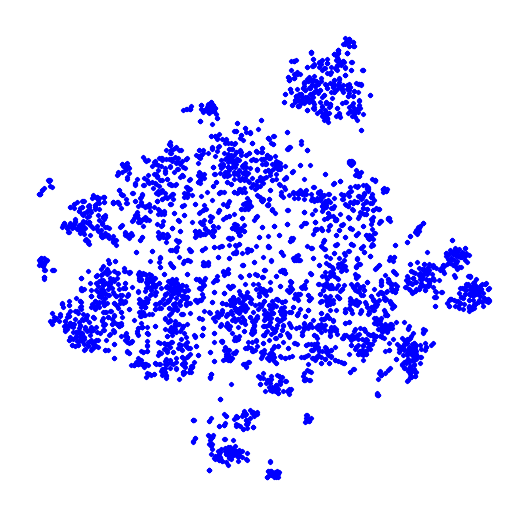

In [39]:
x, y = descriptors_embedding_transformed.transpose()[0], descriptors_embedding_transformed.transpose()[1]
fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')
ax.scatter(x,  y,  2, marker='x', c='b')
plt.axis('off')
plt.show()

### Combined document embedding

We define a new document embedding as a linear combination of already defined ones. After reducing the dimension, we plot it.

In [40]:
# %load -s combemb document_embeddings.py
def combemb(document_embeddings, descriptor_embeddings, alpha):
    """Combines the two embeddings as a linear combination"""
    return alpha*document_embeddings + (1-alpha)*descriptor_embeddings


In [41]:
shortened = non_null[:4000]
print(type(shortened[0]))
#combined = combined_embedding(non_null[:4000, :], descriptors_embedding[:4000, :], 0.5)
#combined_transformed = TSNE(n_components=2, random_state=4).fit_transform(combined)

<class 'numpy.ndarray'>


### Similarity of documents

In this section we will pick a specific document and find others that are most similar to it. We will use methotds we already used for word analysis and more.

We start by picking a document. We'll try to find similar ones.

In [42]:
doc_index = 168
doc_embedded = docembeddings_transformed[doc_index]
documents[doc_index]

{'document_id': 163,
 'document_celex_num': '21990A0515(03)',
 'document_title': 'Agreement in the form of an Exchange of Letters concerning the provisional application of the Protocol defining, for the period 18 January 1990 to 17 January 1993, the fishing opportunities and the financial contribution provided for by the Agreement between the European Economic Community and the Republic of Seychelles on fishing off Seychelles',
 'document_author': 'European Economic Community',
 'document_form': 'International agreement',
 'document_date': datetime.date(1990, 4, 25),
 'document_text': 'Avis juridique important|21990A0515(03)Agreement in the form of an Exchange of Letters concerning the provisional application of the Protocol defining, for the period 18 January 1990 to 17 January 1993, the fishing opportunities and the financial contribution provided for by the Agreement between the European Economic Community and the Republic of Seychelles on fishing off SeychellesOfficial Journal L 12

In [43]:
# %load -s kNN document_embeddings.py
def kNN(embedding, k, de, similarity):
    """Get the k nearest neighbors of a particular document"""

    # calculate the similarities and revert it
    sims = [similarity(embedding, d) for d in de]

    # sort and get the corresponding indices
    indices = []
    for c, index in enumerate(np.argsort(sims)):
        if c == k:
            break
        indices.append(index)

    # return indices of the neighbors
    return indices


We find $k$ documents whose document embeddings are closest to the chosen document. We save their document embeddings in 'doc_neighbors', their distances form chosen document's document embedding in 'doc_distances' and their indices in 'indices'.

In [44]:
k = 20
indices = kNN(doc_embedded, k, XX, similarity=euclid_similarity)

In [45]:
print(indices)

[168, 229, 398, 988, 613, 388, 1377, 983, 1003, 1007, 799, 201, 284, 215, 696, 283, 334, 559, 209, 466]


In [46]:
for i in indices[:5]:
    d = documents[i]
    print(d['document_title'])
    print(' ')

Agreement in the form of an Exchange of Letters concerning the provisional application of the Protocol defining, for the period 18 January 1990 to 17 January 1993, the fishing opportunities and the financial contribution provided for by the Agreement between the European Economic Community and the Republic of Seychelles on fishing off Seychelles
 
Agreement in the form of an exchange of letters concerning the provisional application of the Protocol defining, for the period 18 January 1993 to 17 January 1996, the fishing opportunities and the financial contribution provided for by the Agreement between the European Community and the Republic of Seychelles on fishing off Seychelles
 
Agreement in the form of an Exchange of Letters concerning the provisional application of the Protocol defining, for the period from 18 January to 17 January 1999, the fishing oppportunities and financial contribution provided for by the Agreement between the European Economic Community and the Republic of S

In [47]:
#celex_num = documents[indices[0]]['document_celex_num']
#print("CELEX number of chosen document: {}".format(celex_num))
#neighbors_celex_nums = [documents[i]['document_celex_num'] for i in indices]
#neighbours_documents = []

In [48]:
#neighbors_descriptors = get_descriptors(indices)
#print(neighbors_descriptors)

In [49]:
#neighbors_descriptors_embedding = descriptor_embeddings()

Let's embedd the database with descriptor embedding. On the plot shown below we see the embeddings are close, but not as close as they were when embedded with simple document embedding.

In [50]:
def plot_neighbors(emb, indices):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')
    
    x, y = emb.transpose()[0], emb.transpose()[1]
    ax.scatter(x, y, 2, marker='x', c='b')
    
    temp = emb[indices,:]
    x, y = temp.transpose()[0], temp.transpose()[1]
    ax.scatter(x, y, 10, marker='o', c='r')

    plt.axis('off')
    plt.show()
    return None

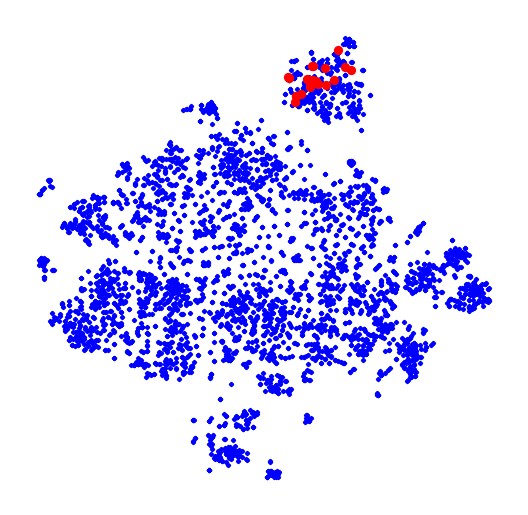

In [51]:
plot_neighbors(descriptors_embedding_transformed, indices)

In [52]:
focus_desc_embedding = descriptors_embedding_transformed[indices[0]]
indices2 = kNN(focus_desc_embedding, k, de=descriptors_embedding_transformed, similarity=euclid_similarity)

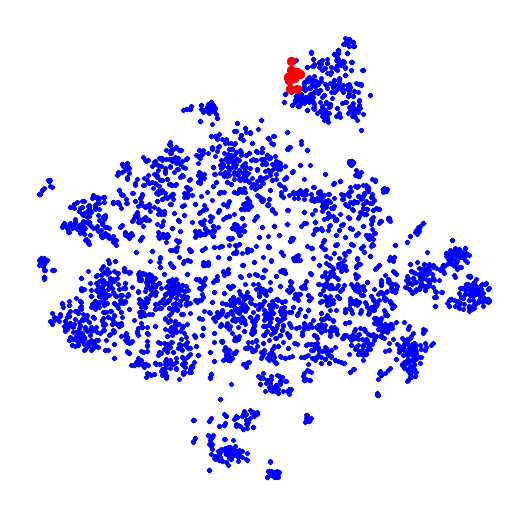

In [53]:
plot_neighbors(descriptors_embedding_transformed, indices2)

In [54]:
for i in indices2[:5]:
    print('Title of neighboring document with id {}: {}'.format(i, documents[i]['document_title']))
    print(' ')

Title of neighboring document with id 168: Agreement in the form of an Exchange of Letters concerning the provisional application of the Protocol defining, for the period 18 January 1990 to 17 January 1993, the fishing opportunities and the financial contribution provided for by the Agreement between the European Economic Community and the Republic of Seychelles on fishing off Seychelles
 
Title of neighboring document with id 169: Protocol defining for the period 18 January 1990 to 17 January 1993 the fishing opportunities and the financial contribution provided for by the Agreement between the European Economic Community and the Republic of Seychelles On fishing off Seychelles
 
Title of neighboring document with id 229: Agreement in the form of an exchange of letters concerning the provisional application of the Protocol defining, for the period 18 January 1993 to 17 January 1996, the fishing opportunities and the financial contribution provided for by the Agreement between the Euro

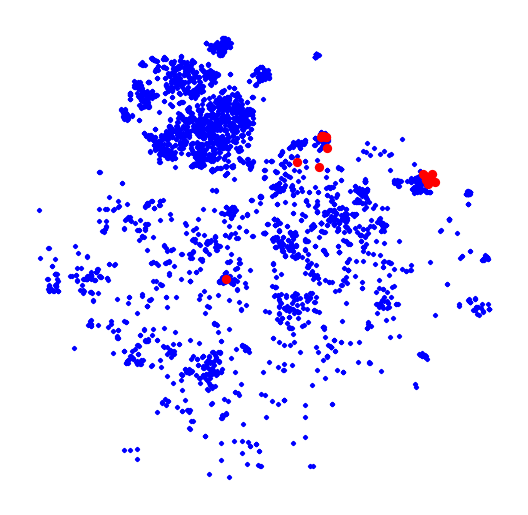

In [55]:
plot_neighbors(XX, indices2)

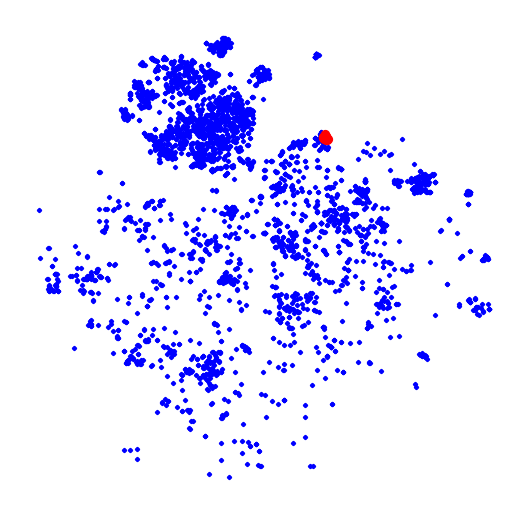

In [56]:
plot_neighbors(XX, indices)

We will plot combined embedding for values of $\alpha = 0,\ 0.25,\ 0.5,\ 0.75,\ 1$. We color $k$ nearest neighbors based on the simple document embedding with red and $k$ nearest neighbors based on the descriptor embedding with yellow.

In [57]:
def plotAlphaBeta(emb1, emb2, alpha, indices1=indices, indices2=indices2):
    emb = combemb(emb1, emb2, alpha)
    temp1 = emb[indices, :]
    temp2 = emb[indices2, :]
    
    fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')
    x, y = emb.transpose()[0], emb.transpose()[1]
    ax.scatter(x,  y,  2, marker='x', c='b') 
    
    x1, y1 = temp1.transpose()[0], temp1.transpose()[1]
    ax.scatter(x1,  y1,  5, marker='o', c='r')
    
    x2, y2 = temp2.transpose()[0], temp2.transpose()[1]
    ax.scatter(x2,  y2,  5, marker='o', c='y')
    
    plt.axis('off')
    plt.show()
    return None

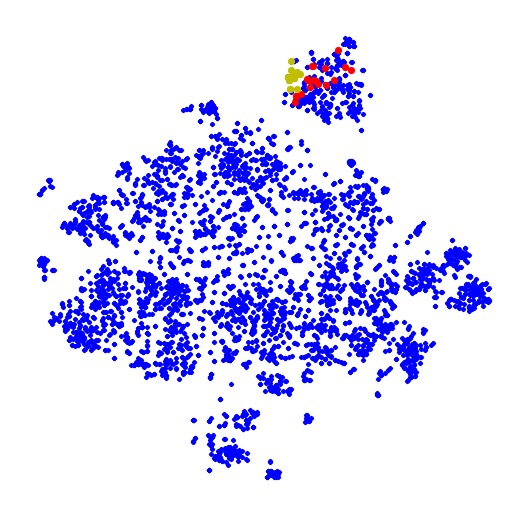

In [58]:
plotAlphaBeta(XX, descriptors_embedding_transformed, 0)

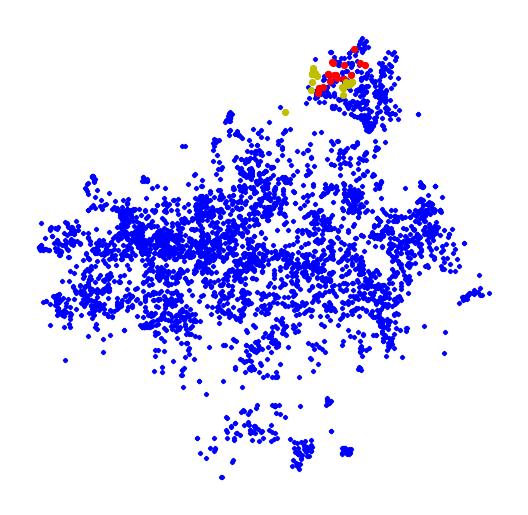

In [59]:
plotAlphaBeta(XX, descriptors_embedding_transformed, 0.25)

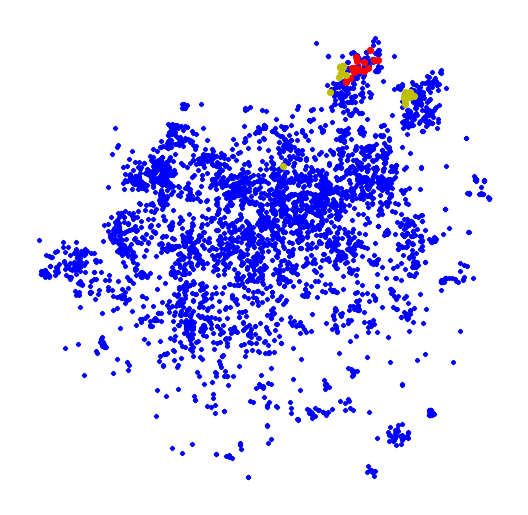

In [60]:
plotAlphaBeta(XX, descriptors_embedding_transformed, 0.5)

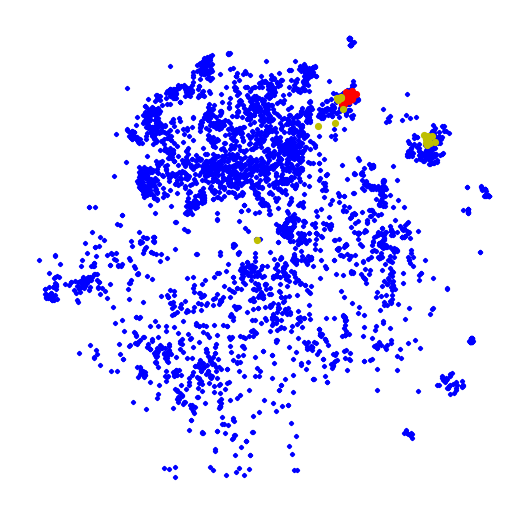

In [61]:
plotAlphaBeta(XX, descriptors_embedding_transformed, 0.75)

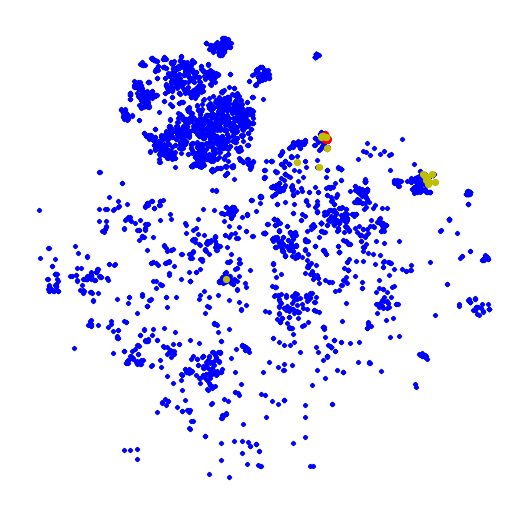

In [62]:
plotAlphaBeta(XX, descriptors_embedding_transformed, 1)

Upper plot shows combined embedding when $\alpha = 1$, which is the same as simple document embedding. We notice that some of the documents that are close when embedded with descriptor embedding (yellow dots), are quite far when embedded with simple document embedding.

Let's find the most distant one.

It doesn't seem like it's quite that different. This in combination with plots of combined embeddings for different $\alpha$ suggests that simple document embedding doesn't represent "closeness" of data quite as well as descriptor embedding. 

Let's test our hypothesis on more exaples.

### Word Movers Distance

In this section we will try to introduce a promising metric for measuring document similarity: Word Movers Distance. It is implemented in gensim library as a function "wmdistance".

First let's pick two documents and compute WMD between them.

In [63]:
index1 = 15
index2 = 3996
doc1 = documents[index1]['document_text']
doc2 = documents[index2]['document_text']

In [64]:
wv_wiki_en.wmdistance(doc1, doc2)

0.09852209221710648

Since WMD is very expensive to compute, we will use it on reduced set of closest neighbors. Let's focuse on 'doc1', find a larger set of neighbouring documents and find the k closest neighbors according to WMD.

In [65]:
k = 100
DET = descriptors_embedding_transformed
candidates_ids = kNN(DET[index1], k, DET, euclid_similarity)

In [66]:
texts = [documents_stripped[i] for i in candidates_ids]
#n = 0
#for i in candidates_ids:
#    texts[n] = documents[i]['document_text']
#    n += 1
k = 10
WMDids = kNN(texts[0], k, texts, wv_wiki_en.wmdistance)

In [67]:
print(WMDids)

[0, 2, 64, 48, 1, 38, 14, 62, 53, 58]


In [68]:
print([candidates_ids[i] for i in WMDids])

[15, 216, 624, 459, 3831, 2042, 2839, 617, 2124, 2840]


In [69]:
for i in WMDids[:5]:
    print(documents[candidates_ids[i]]['document_title'])
    print(' ')

European Convention for the protection of animals kept for farming purposes
 
Protocol of amendment to the European Convention for the protection of animals kept for Farming Purposes
 
Exchange of letters concerning the amendment to the Annexes to the Agreement between the European Community and New Zealand on sanitary measures applicable to trade in live animals and animal products
 
Agreement between the European Community and New Zealand on sanitary measures applicable to trade in live animals and animal products
 
77/505/EEC: Council Decision of 25 July 1977 setting up a Standing Committee on Zootechnics
 


Because WMD distance is very expensive, we want to check, if it makes any sense to even use it. We can choose different embeddings in which to find most similar documents and limit our search to those. For every embedding we find 50, 100, 500 and 1000 nearest neighbors to the chosen document and run our kNN function again for k=10, but this time we use WMD distance.

We plot the results. The ten nearest neigbors are colored with different colors, depending on how many documents we limited our search on. Documents found after limiting ourselves to 50 documents are colored red, 100 green, 500 yellow and 1000 violet.

In [70]:
def compare_results_WMD(id1=index1, emb=XX):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')
    x, y = emb.transpose()[0], emb.transpose()[1]
    ax.scatter(x,  y,  2, marker='x', c='b') 
    colors = {50: 'r', 100: 'g', 500: 'y', 1000: 'm'}
    
    for k in [50, 100, 500, 1000]:
        candidates_ids = kNN(emb[id1], k, emb, euclid_similarity)
        texts = [documents_stripped[i] for i in candidates_ids]
        WMDids = kNN(texts[0], 10, texts, wv_wiki_en.wmdistance)
        WMDids = [candidates_ids[i] for i in WMDids]
        temp = emb[WMDids, :]
        x, y = temp.transpose()[0], temp.transpose()[1]
        ax.scatter(x, y, 10, marker='o', c=colors[k])
        
    plt.axis('off')
    plt.show()
    
    return None

Using document embedding by average.

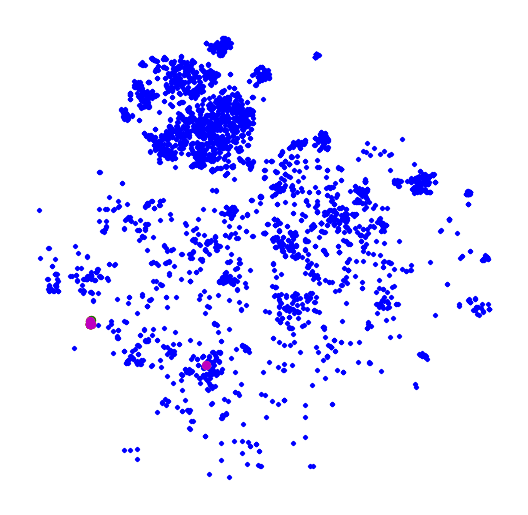

In [71]:
compare_results_WMD()

Using document embedding by descriptors.

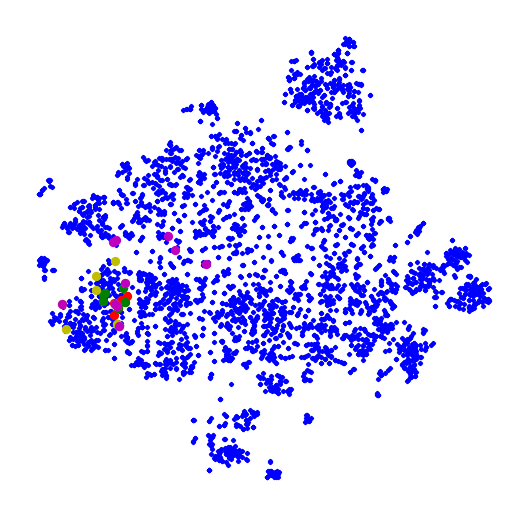

In [72]:
compare_results_WMD(emb=descriptors_embedding_transformed)

Using combined document embedding where each embedding contributes $\alpha = 0.5$.

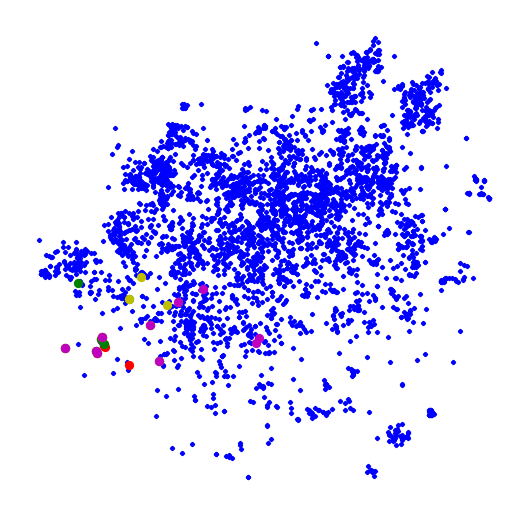

In [73]:
compare_results_WMD(emb=combemb(docembeddings_transformed[:4000,:], descriptors_embedding_transformed, 0.5))

We see that in the case of combined embedding results of our search for nearest documents differ the least depending on the limit of documents we set. This suggests that using combined embedding might be profitable and might produce the best results.

Let's test our hypothesis on other examples.

In [74]:
from random import randint
id1 = randint(0, 4000)

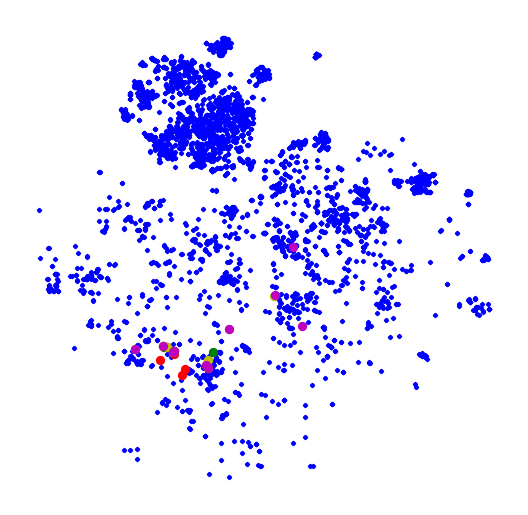

In [75]:
compare_results_WMD(id1=id1)

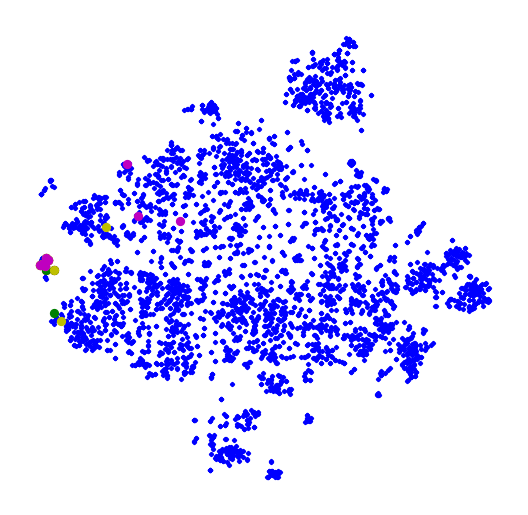

In [76]:
compare_results_WMD(id1=id1,emb=descriptors_embedding_transformed)

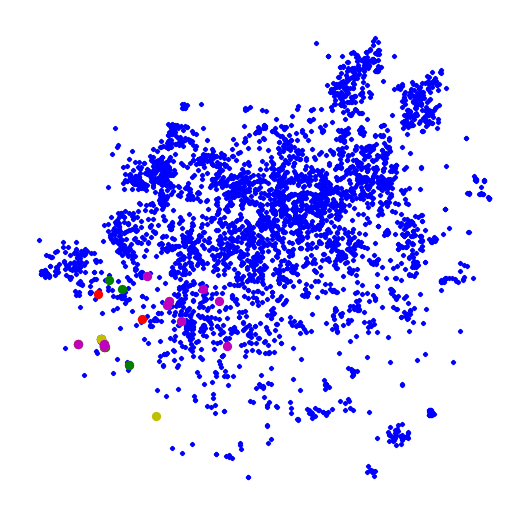

In [77]:
compare_results_WMD(id1=id1, emb=combemb(docembeddings_transformed[:4000,:], descriptors_embedding_transformed, 0.5))

## Training word embedding model

The library ' gensim' enables us to train our own word-embedding model based on pretrained FastText model. We use all the text from all our documents and use the model to perform analysis of documents and their similarity.

We trained our model seperately in order to avoid running expensive code with every run of the notebook. The training is done in the following way:

```python
from gensim.models import FastText

trained_model = FastText(size=4, window=3, min_count=1)
trained_model.build_vocab(sentences=documents_stripped)
trained_model.train(sentences=documents_stripped, total_examples=len(documents_stripped), epochs=10)
```

The model is saved and available in this GitHub repository at [this link](https://github.com/ZivaUrbancic/enviroLENS/tree/master/word-embeddings/data/fasttext).

In [78]:
from gensim.models import FastText
path_tm = '../data/fasttext/trained_model.vec'
trained_model = FastText.load(path_tm)

In [96]:
trained_model.wv.vector_size

300

In [81]:
limit = 15000
# limit = 50
we_trained = dataset_embedding(documents[:limit], stop_words, trained_model.wv, simple_docemb)

Processed document number = 0
Processed document number = 10000


In [82]:
# trained_docemb_transformed = TSNE(n_components=2, random_state=rand_seed).fit_transform(we_trained[:4000,:])

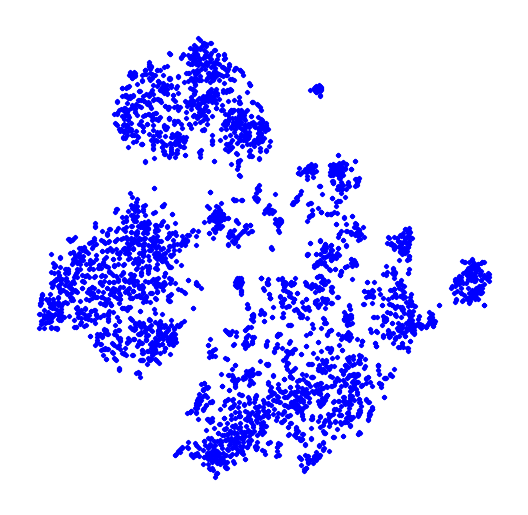

In [83]:
# get the (x, y) coordinates
x, y = trained_docemb_transformed.transpose()[0], trained_docemb_transformed.transpose()[1]
# draw the points into the landscape
fig, ax = plt.subplots(figsize=(4, 4), dpi=160, facecolor='w')
ax.scatter(x,  y,  2, marker='x', c='b')
# show the image
plt.axis('off')
plt.show()

In [84]:
k = 10
tr_indices = kNN(trained_docemb_transformed[doc_index], k, trained_docemb_transformed, euclid_similarity)

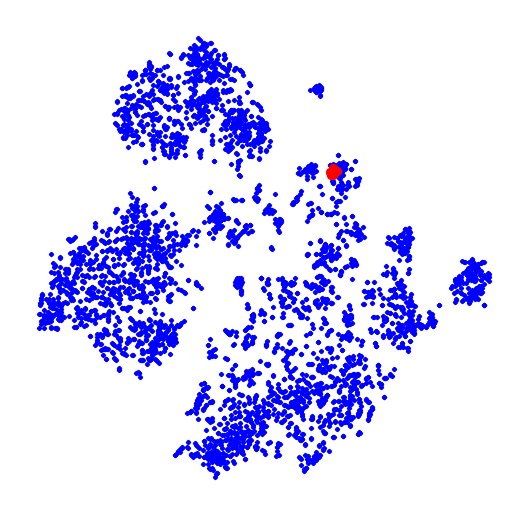

In [85]:
plot_neighbors(trained_docemb_transformed, tr_indices)

Let's plot the nearest neighbors we got from embedding the documents as average of Word2Vec vectors of words and then do the same with the nearest neighbors in embedding based on embedding of document descriptors.

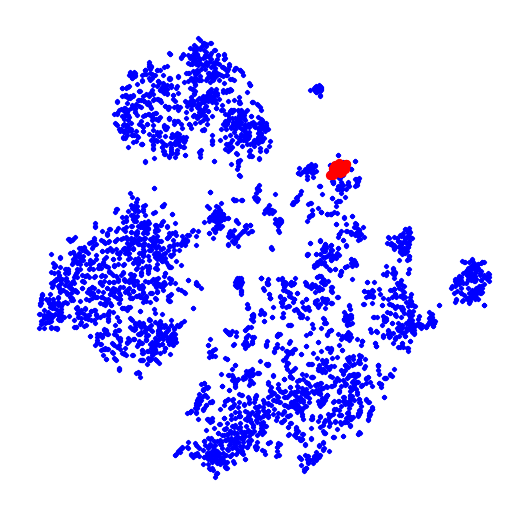

In [86]:
plot_neighbors(trained_docemb_transformed, indices)

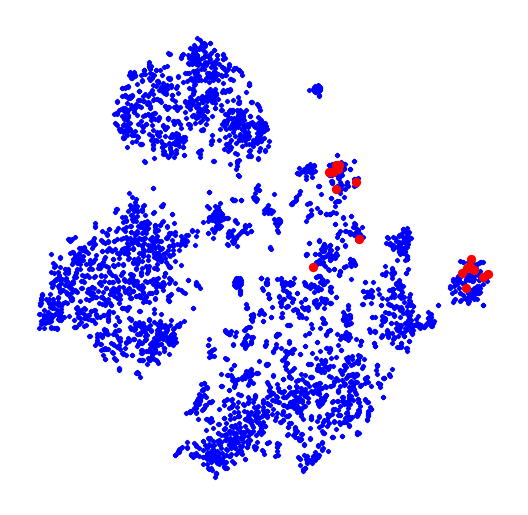

In [87]:
plot_neighbors(trained_docemb_transformed, indices2)

In [88]:
# compare_results_WMD(emb=trained_docemb_transformed, metric=trained_model.wmdistance)

We managed to get different lists of k nearest neighbors for different embeddings. A measure of how well they perform might be Word Movers Distance. Let's compute it for all elements in those lists.

In [89]:
texts = [documents_stripped[i] for i in indices]
dist1 = [wv_wiki_en.wmdistance(t, texts[0]) for t in texts]
av1 = sum(dist1)/len(dist1)

In [90]:
texts = [documents_stripped[i] for i in indices2]
dist2 = [wv_wiki_en.wmdistance(t, texts[0]) for t in texts]
av2 = sum(dist2)/len(dist2)

In [91]:
texts = [documents_stripped[i] for i in tr_indices]
dist3 = [wv_wiki_en.wmdistance(t, texts[0]) for t in texts]
av3 = sum(dist3)/len(dist3)

In [92]:
print("Word Movers Distances of kNN for simple document embedding: {}".format(["%.2f"%i for i in dist1]))
print("Average: {}".format("%.2f" % av1))
print(" ")
print("Word Movers Distances of kNN for descriptor embedding: {}".format(["%.2f"%i for i in dist2]))
print("Average: {}".format("%.2f" % av2))
print(" ")
print("Word Movers Distances of kNN for document embedding trained on our data: {}".format(["%.2f"%i for i in dist3]))
print("Average: {}".format("%.2f" % av3))

Word Movers Distances of kNN for simple document embedding: ['0.00', '0.03', '0.02', '0.03', '0.02', '0.05', '0.07', '0.06', '0.08', '0.09', '0.05', '0.06', '0.09', '0.07', '0.05', '0.08', '0.08', '0.07', '0.06', '0.08']
Average: 0.06
 
Word Movers Distances of kNN for descriptor embedding: ['0.00', '0.14', '0.03', '0.13', '0.05', '0.05', '0.13', '0.06', '0.14', '0.15', '0.21', '0.18', '0.14', '0.14', '0.16', '0.17', '0.07', '0.13', '0.20', '0.20']
Average: 0.12
 
Word Movers Distances of kNN for document embedding trained on our data: ['0.00', '0.02', '0.05', '0.02', '0.08', '0.03', '0.06', '0.06', '0.05', '0.08']
Average: 0.05


In [93]:
def compare_distances(document_id, k):
    indices =  kNN(XX[document_id], k, XX, euclid_similarity)
    indices2 = kNN(descriptors_embedding_transformed[document_id], k, 
                   descriptors_embedding_transformed, euclid_similarity)
    indices3 = kNN(trained_docemb_transformed[document_id], k, trained_docemb_transformed, euclid_similarity)
    I = [indices, indices2, indices3]
    av = [0, 0, 0]
    for i in range(3):
        texts = [documents_stripped[j] for j in I[i]]
        dist = [wv_wiki_en.wmdistance(t, texts[0]) for t in texts]
        av[i] = sum(dist)/len(dist)
    return av    

In [94]:
averages = [0, 0, 0]
for i in range(500):
    c = compare_distances(i, 10)
    averages = [averages[j] + c[j] for j in range(3)]
print(averages)

[36.787298862217135, 48.29431442884302, 38.35375855280535]
